In [1]:
# Librerías necesarias para el estudio
import pandas as pd
import networkx as nx 
import numpy as np
import os.path
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chi2_contingency
from tabulate import tabulate
from itertools import combinations
from sklearn import metrics, svm, linear_model
from sklearn.model_selection import train_test_split
from neuroCombat import neuroCombat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
from combat.pycombat import pycombat

# 1. Importación de datos

In [2]:
# Listado de regiones cerebrales (en su respectivo orden de aparición en las matrices de conectividad)
nodes = pd.read_csv('Datasets/mindboggle_ROIs.txt', sep='\t')["[ sROI_MINDBOGGLE]"].to_list()
num_nodes = len(nodes)
edges = [tuple(sorted(c, key=str.casefold)) for c in combinations(nodes,2) if c[0]!=[1]]

# Listado de variables que tendremos en cuenta (posiciones [i,j] de la diagonal superior de las matrices)
variables = []
for i in range(0,num_nodes):
    for j in range(i+1,num_nodes):
        variables.append((i,j))

# Datos clínicos de los sujetos
clinic = pd.read_csv('Datasets/clinic.csv')

# Modificamos el datatype de la variable 'sex' para que sea categórica
clinic['sex'] = clinic['sex'].astype('category')

# Listado de identificadores de cada uno de los grupos (pacientes/controles)
patients = dict.fromkeys(clinic[clinic.controls_ms==1]['id'].to_list())
controls = dict.fromkeys(clinic[clinic.controls_ms==0]['id'].to_list())

# Matrices de conectividad de cada uno de los sujetos 
def import_connectivity_matrix(subjects):
    '''
    Dada una lista de IDs, esta función retorna
    las matrices FA, GM y rfMRI para cada uno de ellos
    en formato diccionario {ID : {FA: [], GM: [], rfMRI: []}}
    '''
    for s in subjects:
        subjects[s]               = dict.fromkeys(['FA','GM','rfMRI'])
        subjects[s]['FA']         = pd.read_csv('Datasets/subject_networks_FA_v1/'       + s +'_FA_factor.csv', header=None)
        subjects[s]['GM']         = pd.read_csv('Datasets/subject_networks_GM_v1-no-thr/'+ s +'_GM_matrix.csv', header=None)
        subjects[s]['rfMRI']      = pd.read_csv('Datasets/subject_networks_rfMRI_v1/'    + s +'_r_matrix.csv' , header=None)
        subjects[s]['zAttention'] = list(clinic[clinic.id == s]['zattention'])[0]

        
import_connectivity_matrix(patients)
import_connectivity_matrix(controls)

In [3]:
print("Número de sujetos: {}".format(len(patients)+len(controls)))
print("Número de regiones cerebrales: {}".format(len(nodes)))
print("Número de conexiones cerebrales: {}".format(len(edges)))

Número de sujetos: 165
Número de regiones cerebrales: 76
Número de conexiones cerebrales: 2850


In [4]:
patients_bkp_1 = patients.copy()
controls_bkp_1 = controls.copy()

In [5]:
patients['002MSVIS']['FA'][0][1]

0.395567104681496

# 2. Preprocesamiento de datos

## 2.1. Correción por edad y sexo

In [6]:
# Variable para almacenar el valor medio de cada variable (i,j) solo para los controles
control_means = dict.fromkeys(['FA','GM','rfMRI'])

for t in ['FA','GM','rfMRI']:
    control_means[t] = {} 
    
    for (i,j) in variables: 
        
        # Calculamos, para cada variable [i,j], la media de los valores de los sujetos control (solo diagonal superior)
        control_means[t][(i,j)] = np.mean([controls[s][t][i][j] for s in controls])        
    
        # De cada sujeto, recuperamos el sexo, la edad y el valor real de la variable
        subjects = []
        age = []
        gender = []
        real_values = []
        
        for group in [controls,patients]:
            for s in group:
                subjects.append(s)
                age.append(list(clinic[clinic.id==s]['age'])[0])  
                gender.append(list(clinic[clinic.id==s]['sex'])[0])               
                real_values.append(group[s][t][i][j])
                
        # Ajustamos los valores a una regresión lineal en función de la edad y el sexo
        x = [age,gender]; x = np.array(x).T
        y = real_values; y = np.array(y)
        new_values = linear_model.LinearRegression().fit(x,y).predict(x)
        
        # Reemplazamos el valor actual por el nuevo valor
        for group in [controls,patients]:
            for s in group: 
                    k = subjects.index(s)
                    group[s][t][i][j]=real_values[k]-new_values[k]+control_means[t][(i,j)]

In [7]:
patients_bkp_2_1 = patients.copy()
controls_bkp_2_1 = controls.copy()

In [8]:
patients['002MSVIS']['FA'][0][1]

0.422861501609871

## 2.2. Valores nulos

## 2.3. Normalización de datos

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizamos cada una de las variables
for t in ['FA','GM','rfMRI']:
    for (i,j) in variables:
        
        # De cada sujeto, recuperamos el valor real de la variable
        subjects = []
        real_values = []
        
        for group in [controls,patients]:
            for s in group:
                subjects.append(s)               
                real_values.append(group[s][t][i][j])
        
        # Normalizamos
        new_values = scaler.fit_transform(np.array(real_values).reshape(-1, 1))    
        
        # Reemplazamos el valor actual por el nuevo valor
        for group in [controls,patients]:
            for s in group: 
                k = subjects.index(s)
                group[s][t][i][j]=new_values[k]

In [10]:
patients_bkp_2_3 = patients.copy()
controls_bkp_2_3 = controls.copy()

In [11]:
patients['002MSVIS']['FA'][0][1]

0.6566064878727926

## 2.4. Harmonización de pesos

In [12]:
from combat.pycombat import pycombat

for t in ['FA']:
    for (i,j) in variables: 
        
        # De cada sujeto, recuperamos el site y el valor real de la variable
        subjects = []
        sites = []
        real_values = []
        
        for group in [controls,patients]:
            for s in group:
                subjects.append(s)
                sites.append(1 if 'MSVIS' in s else 2)                
                real_values.append(group[s][t][i][j])
                
        # Harmonización de pesos
        data = pd.DataFrame(np.array(real_values).T).T
        batch = sites
        new_values = pycombat(data,batch,mean_only=True).T
        new_values = new_values.T
        
        # Reemplazamos el valor actual por el nuevo valor
        for group in [controls,patients]:
            for s in group: 
                k = subjects.index(s)
                group[s][t][i][j]=new_values[k]

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Loc

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Loc

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Loc


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encounte


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use floa

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaconda\lib\site-packages\combat\pycombat.py:498: RuntimeWarning: invalid value encountered in divide
  s_data = np.divide((dat - stand_mean), \
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a si

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\ProgramData\Anaco


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]



Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametri

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD


Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametr

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S mo

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppD

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17356/585815582.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


In [13]:
patients_bkp_2_4 = patients.copy()
controls_bkp_2_4 = controls.copy()

In [14]:
patients['002MSVIS']['FA'][0][1]

0.676619585584249

In [ ]:
# ejecución hasta aquí

In [34]:
test = patients['002MSVIS']['FA']; test

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0.000000,0.395567,0.000000,0.000000,0.000000,0.382439,0.392177,0.490902,0.000000,0.356278,...,0.427563,0.000000,0.000000,0.403237,0.443410,0.000000,0.000000,0.000000,0.000000,0.406224
1,0.676620,0.000000,0.390811,0.000000,0.399301,0.393108,0.407948,0.429956,0.387595,0.320350,...,0.464181,0.446113,0.000000,0.406583,0.456822,0.454321,0.000000,0.413500,0.000000,0.427451
2,-0.024905,0.745236,0.000000,0.398220,0.337794,0.331889,0.371555,0.405719,0.279199,0.382179,...,0.000000,0.514403,0.000000,0.000000,0.000000,0.485932,0.487580,0.476371,0.000000,0.499687
3,NaN,0.024376,0.737943,0.000000,0.246662,0.381574,0.273955,0.340575,0.368603,0.000000,...,0.000000,0.444677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.010847,0.736844,0.747037,0.594432,0.000000,0.370097,0.336514,0.408971,0.326297,0.385381,...,0.000000,0.484955,0.000000,0.000000,0.000000,0.480998,0.468261,0.464757,0.000000,0.477383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.112033,0.827838,0.813866,-0.075397,0.768288,0.612739,0.793462,0.827913,0.825469,0.063409,...,0.400153,0.412027,0.104479,0.855339,0.609605,0.000000,0.383278,0.343662,0.407336,0.405019
72,0.001930,-0.126237,0.613547,-0.004126,0.525927,0.854516,0.507153,0.818255,0.613823,0.145402,...,0.802664,0.526918,0.889515,0.862059,0.528534,0.378826,0.000000,0.307111,0.330551,0.378112
73,0.062758,0.843090,0.728025,0.059372,0.631908,0.846919,0.572029,0.860509,0.626128,0.012995,...,0.550954,0.365610,0.098223,0.819744,0.568431,0.392081,0.410521,0.000000,0.356339,0.342213
74,NaN,0.037762,0.034804,NaN,NaN,-0.036137,-0.031931,0.022327,0.010309,0.025564,...,0.068692,0.633313,0.003481,0.069418,0.138949,0.543816,0.599753,0.781752,0.000000,0.345007


## 2.5. Aplicación de umbrales y filtrado de conexiones


In [36]:
# eliminamos cualquier conectividad <0.1 o nan (las ponemos a cero) 
for group in [patients, controls]:
    for s in group:
        for matrix in ['FA','GM','rfMRI']:
            #pos = len(group[s][matrix])
            #for i in range(0,pos):
                #for j in range(0,pos): 
            for (i,j) in variables:
                if group[s][matrix][i][j] < 0.1 or np.isnan(group[s][matrix][i][j]) == True:
                    group[s][matrix][i][j] = 0

In [37]:
patients['002MSVIS']['FA']

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0.000000,0.395567,0.000000,0.000000,0.000000,0.382439,0.392177,0.490902,0.000000,0.356278,...,0.427563,0.000000,0.000000,0.403237,0.443410,0.000000,0.000000,0.000000,0.000000,0.406224
1,0.676620,0.000000,0.390811,0.000000,0.399301,0.393108,0.407948,0.429956,0.387595,0.320350,...,0.464181,0.446113,0.000000,0.406583,0.456822,0.454321,0.000000,0.413500,0.000000,0.427451
2,0.000000,0.745236,0.000000,0.398220,0.337794,0.331889,0.371555,0.405719,0.279199,0.382179,...,0.000000,0.514403,0.000000,0.000000,0.000000,0.485932,0.487580,0.476371,0.000000,0.499687
3,0.000000,0.000000,0.737943,0.000000,0.246662,0.381574,0.273955,0.340575,0.368603,0.000000,...,0.000000,0.444677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.736844,0.747037,0.594432,0.000000,0.370097,0.336514,0.408971,0.326297,0.385381,...,0.000000,0.484955,0.000000,0.000000,0.000000,0.480998,0.468261,0.464757,0.000000,0.477383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.112033,0.827838,0.813866,0.000000,0.768288,0.612739,0.793462,0.827913,0.825469,0.000000,...,0.400153,0.412027,0.104479,0.855339,0.609605,0.000000,0.383278,0.343662,0.407336,0.405019
72,0.000000,0.000000,0.613547,0.000000,0.525927,0.854516,0.507153,0.818255,0.613823,0.145402,...,0.802664,0.526918,0.889515,0.862059,0.528534,0.378826,0.000000,0.307111,0.330551,0.378112
73,0.000000,0.843090,0.728025,0.000000,0.631908,0.846919,0.572029,0.860509,0.626128,0.000000,...,0.550954,0.365610,0.000000,0.819744,0.568431,0.392081,0.410521,0.000000,0.356339,0.342213
74,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.633313,0.000000,0.000000,0.138949,0.543816,0.599753,0.781752,0.000000,0.345007


In [38]:
counter = {}

# Calculamos, para cada variable, el número de sujetos controles en las que se encuentra presente
for (i,j) in variables: 
    counter[(i,j)] =0
    for s in controls:
        if controls[s]['FA'][i][j]!=0: 
            counter[(i,j)] = counter[(i,j)] + 1

# conexiones que aparecen en más del 60% de los controles
conexiones = [c for c in counter if counter[c]/len(controls)>=0.6]
print(len(conexiones))

# Eliminamos aquellas que no se encuentran en el listado anterior
for group in [patients, controls]:
    for s in group:
        for matrix in ['FA','GM','rfMRI']:
            for (i,j) in variables:
                if (i,j) not in conexiones:
                    group[s][matrix][i][j] = 0

2096


In [39]:
patients['002MSVIS']['FA']

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0.000000,0.395567,0.000000,0.000000,0.000000,0.382439,0.392177,0.490902,0.000000,0.356278,...,0.427563,0.000000,0.000000,0.403237,0.443410,0.000000,0.000000,0.000000,0.000000,0.406224
1,0.676620,0.000000,0.390811,0.000000,0.399301,0.393108,0.407948,0.429956,0.387595,0.320350,...,0.464181,0.446113,0.000000,0.406583,0.456822,0.454321,0.000000,0.413500,0.000000,0.427451
2,0.000000,0.745236,0.000000,0.398220,0.337794,0.331889,0.371555,0.405719,0.279199,0.382179,...,0.000000,0.514403,0.000000,0.000000,0.000000,0.485932,0.487580,0.476371,0.000000,0.499687
3,0.000000,0.000000,0.737943,0.000000,0.246662,0.381574,0.273955,0.340575,0.368603,0.000000,...,0.000000,0.444677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.736844,0.747037,0.594432,0.000000,0.370097,0.336514,0.408971,0.326297,0.385381,...,0.000000,0.484955,0.000000,0.000000,0.000000,0.480998,0.468261,0.464757,0.000000,0.477383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.112033,0.827838,0.813866,0.000000,0.768288,0.612739,0.793462,0.827913,0.825469,0.000000,...,0.400153,0.412027,0.104479,0.855339,0.609605,0.000000,0.383278,0.343662,0.407336,0.405019
72,0.000000,0.000000,0.613547,0.000000,0.525927,0.854516,0.507153,0.818255,0.613823,0.145402,...,0.802664,0.526918,0.889515,0.862059,0.528534,0.378826,0.000000,0.307111,0.330551,0.378112
73,0.000000,0.843090,0.728025,0.000000,0.631908,0.846919,0.572029,0.860509,0.626128,0.000000,...,0.550954,0.365610,0.000000,0.819744,0.568431,0.392081,0.410521,0.000000,0.356339,0.342213
74,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.633313,0.000000,0.000000,0.138949,0.543816,0.599753,0.781752,0.000000,0.345007


# 3. Estudio de los datos clínicos y demográficos

In [42]:
def mean_std(col,new_label,only_ms=0):
    '''
    Function that returns an array with four elements:
        - new_label
        - mean+std for patients
        - mean+std for controls (only if only_ms=0)
        - Student t-test p-value (only if only_ms=0)
    '''
    variable = [new_label]
    col_patients = clinic[clinic.controls_ms == 1][col]
        
    # [mean, std] for MS patients
    variable.append(col_patients.agg(['mean','std']).round(2).to_list())
    
    if only_ms == 0: 
        
        # [mean, std] for controls
        col_controls = clinic[clinic.controls_ms == 0][col]
        variable.append(col_controls.agg(['mean','std']).round(2).to_list())
        
        # Student t-test
        variable.append(mannwhitneyu(col_patients.to_list(),
                                  col_controls.to_list())
                        .pvalue)
    else:
        variable.append("n/a")
        variable.append("n/a")

    return variable


def count_pct(col,new_label):
    variable = [new_label]
    
    col_patients = list(clinic[clinic.controls_ms == 1][col])
    col_controls = list(clinic[clinic.controls_ms == 0][col])
        
    # [mean, std] for MS patients
    counts = Counter(col_patients)
    variable.append([counts[0],round(counts[0]/(counts[0]+counts[1]),2)])    
    
    # [mean, std] for MS controls
    counts = Counter(col_controls)
    variable.append([counts[0],round(counts[0]/(counts[0]+counts[1]),2)])  
    
    # test
    pvalue = chi2_contingency([list(Counter(col_patients).values()),
                               list(Counter(col_controls).values())])[1]
    variable.append(pvalue)
    
    return variable
    
data = []
data.append(mean_std('age','Age'))
data.append(count_pct('sex','Sex (F, %)'))
data.append(mean_std('dd','Disease duration',only_ms=1))
data.append(mean_std('zpasat','zPASAT score',only_ms=1))
data.append(mean_std('sdmtz','zSDMT score',only_ms=1))
data.append(mean_std('zattention','zAttention score',only_ms=1))


print (tabulate(data, headers=["Variable", "MS Patients", "Controls", "p-valor"]))

Variable          MS Patients     Controls      p-valor
----------------  --------------  ------------  ----------------------
Age               [47.33, 10.15]  [36.62, 9.6]  0.00017663447852410628
Sex (F, %)        [104, 0.71]     [15, 0.83]    0.39784392998317575
Disease duration  [15.96, 9.05]   n/a           n/a
zPASAT score      [-0.29, 1.33]   n/a           n/a
zSDMT score       [0.08, 1.06]    n/a           n/a
zAttention score  [-0.29, 1.04]   n/a           n/a


# 4. Cálculo de métricas de grafos

## 4.1. Transformación a grafos

In [43]:
def sym_matrix_to_graph (data, nodes):
    """
    Dada una matriz simetrica 'data' donde v[i,j] es el valor de la posición [i,j],
    se retorna un grafo con aristas [i,j], con nombre de los nodos nodes[i] y nodes[j], 
    y peso de la arista v[i,j]
    """
    # Declaramos la lista donde se almacenarán los diferentes pares de aristas y pesos
    weighted_edges = []

    # Calculamos las aristas y sus correspondientes pesos
    for (i,j) in variables:
        # no consideramos aristas aquellas conectividades que son 0
        if data[i][j]!=0# and pd.isna(data[i][j])==False:
            weighted_edges.append((nodes[i], nodes[j],data[i][j]))

    # Generamos el grafo correspondiente
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    # Retornamos el grafo
    return G


def connectivity_graphs(subjects, nodes):
    '''
    Dado un diccionario {ID : {FA: [], GM: [], rfMRI: []}}, donde los [] corresponden
    a datasets, esta función aplica sym_matrix_to_graph() function a cada dataset
    '''
    for s in subjects.keys():
        subjects[s]['FA']    = sym_matrix_to_graph(subjects[s]['FA'],nodes)
        subjects[s]['GM']    = sym_matrix_to_graph(subjects[s]['GM'],nodes)
        subjects[s]['rfMRI'] = sym_matrix_to_graph(subjects[s]['rfMRI'],nodes)
        
connectivity_graphs(patients,nodes)
connectivity_graphs(controls,nodes)

## 4.2. Métricas globales

- strength (sum of all neighboring link weights)
- transitivity (ratio of triangles to triplets in the network)
- global efficiency (average inverse shortest path length)
- assortativity (correlation coefficient between the degrees of all nodes on two opposite ends of a link)
- path length
- betweenness centrality (fraction of all shortest paths in the network that pass through a given node) 

In [44]:
def graph_global_metrics(graph_list):
    '''
    Dada una lista de grafos, esta función retorna, para cada uno de ellos las siguientes
    métricas: strength, transitivity, global efficiency, assortativity, clustering coefficient,
    betwenness centrality
    '''
    cmetrics = {}
    
    # Cálculo de métricas
    cmetrics['Strength']                         = [np.sum([w[1] for w in list(G.degree(weight='weight'))])
                                                   for G in graph_list]
    cmetrics['Transitivity']                     = [nx.transitivity(G) for G in graph_list]
    cmetrics['Global efficiency']                = [nx.global_efficiency(G,) for G in graph_list]
    cmetrics['Assortativity']                    = [nx.degree_pearson_correlation_coefficient(G,weight='weight') 
                                                   for G in graph_list]
    cmetrics['Path length']                      = [nx.average_shortest_path_length(G) for G in graph_list]
    cmetrics['Betweenness centrality']           = [np.mean(list(nx.betweenness_centrality(G,weight='weight').values())) 
                                                   for G in graph_list]
    # Retornamos los resultados
    return cmetrics


def global_metrics_summary(patients_metrics,controls_metrics, metrics):
    '''
    Retorna una tabla con el resumen de las métricas para ambos grupos de sujetos
    y el pvalor correspondiente
    '''
    data=[]
    
    for m in metrics:
        row = [m]

        patients_stats = (np.mean(patients_metrics[m]) .round(2),
                          np.std (patients_metrics[m]) .round(2))
        controls_stats = (np.mean(controls_metrics[m]) .round(2),
                          np.std (controls_metrics[m]) .round(2))
        pvalue = mannwhitneyu(patients_metrics[m], controls_metrics[m]).pvalue
        
        row.append(patients_stats)
        row.append(controls_stats)
        row.append(pvalue)
        data.append(row)
        
    return data
 

def bonferroni_correction(data):
    '''
    Aplicación de corrección de Bonferroni
    '''
    pvals = [row[3] for row in data]
    adjusted_pvals = list(multipletests(pvals, method='bonferroni',is_sorted=False,returnsorted=False)[1])

    i = 0
    for row in data:
        row[3] = adjusted_pvals[i]
        i=i+1

### 4.2.1. Conectividad estructural

In [45]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_FA = [patients[s]['FA'] for s in patients.keys()]
controls_FA = [controls[s]['FA'] for s in controls.keys()]

In [46]:
# Cálculo de métricas de grafos globales
patients_FA_metrics = graph_global_metrics(patients_FA)
controls_FA_metrics = graph_global_metrics(controls_FA)
cmetrics             = patients_FA_metrics.keys()

In [47]:
data = global_metrics_summary(patients_FA_metrics,controls_FA_metrics,cmetrics)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls                pvalue
----------------------  -----------------  -----------------  -----------
Strength                (2498.57, 319.98)  (2806.52, 155.67)  1.17201e-05
Transitivity            (0.77, 0.03)       (0.78, 0.01)       0.14404
Global efficiency       (0.84, 0.02)       (0.85, 0.01)       0.116246
Assortativity           (-0.07, 0.03)      (-0.08, 0.02)      0.0147551
Path length             (1.32, 0.04)       (1.3, 0.02)        0.119304
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.947907


In [48]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls                pvalue
----------------------  -----------------  -----------------  -----------
Strength                (2498.57, 319.98)  (2806.52, 155.67)  7.03208e-05
Transitivity            (0.77, 0.03)       (0.78, 0.01)       0.864241
Global efficiency       (0.84, 0.02)       (0.85, 0.01)       0.697477
Assortativity           (-0.07, 0.03)      (-0.08, 0.02)      0.0885306
Path length             (1.32, 0.04)       (1.3, 0.02)        0.715824
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        1


### 4.2.2. Conectividad morfológica

In [49]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_GM = [patients[s]['GM'] for s in patients.keys()]
controls_GM = [controls[s]['GM'] for s in controls.keys()]

In [50]:
# Cálculo de métricas de grafos globales
patients_GM_metrics = graph_global_metrics(patients_GM)
controls_GM_metrics = graph_global_metrics(controls_GM)
cmetrics             = patients_GM_metrics.keys()

In [51]:
data = global_metrics_summary(patients_GM_metrics,controls_GM_metrics,cmetrics)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (1984.53, 392.82)  (1937.39, 310.62)  0.677749
Transitivity            (0.8, 0.02)        (0.8, 0.02)        0.334294
Global efficiency       (0.86, 0.01)       (0.86, 0.01)       0.308623
Assortativity           (-0.07, 0.03)      (-0.06, 0.02)      0.0908574
Path length             (1.28, 0.03)       (1.28, 0.03)       0.308623
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.249105


In [52]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls             pvalue
----------------------  -----------------  -----------------  --------
Strength                (1984.53, 392.82)  (1937.39, 310.62)  1
Transitivity            (0.8, 0.02)        (0.8, 0.02)        1
Global efficiency       (0.86, 0.01)       (0.86, 0.01)       1
Assortativity           (-0.07, 0.03)      (-0.06, 0.02)      0.545144
Path length             (1.28, 0.03)       (1.28, 0.03)       1
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        1


### 4.2.3. Conectividad funcional

In [53]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_rfMRI = [patients[s]['rfMRI'] for s in patients.keys()]
controls_rfMRI = [controls[s]['rfMRI'] for s in controls.keys()]

In [54]:
# Cálculo de métricas de grafos globales
patients_rfMRI_metrics = graph_global_metrics(patients_rfMRI)
controls_rfMRI_metrics = graph_global_metrics(controls_rfMRI)
cmetrics                = patients_rfMRI_metrics.keys()

In [55]:
data = global_metrics_summary(patients_rfMRI_metrics,controls_rfMRI_metrics,cmetrics)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (2467.42, 290.08)  (2321.09, 365.85)  0.0879015
Transitivity            (0.8, 0.01)        (0.79, 0.02)       0.0272111
Global efficiency       (0.86, 0.01)       (0.86, 0.01)       0.0212379
Assortativity           (-0.04, 0.03)      (-0.02, 0.05)      0.0290934
Path length             (1.28, 0.01)       (1.29, 0.02)       0.0212379
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.0340482


In [56]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls             pvalue
----------------------  -----------------  -----------------  --------
Strength                (2467.42, 290.08)  (2321.09, 365.85)  0.527409
Transitivity            (0.8, 0.01)        (0.79, 0.02)       0.163267
Global efficiency       (0.86, 0.01)       (0.86, 0.01)       0.127427
Assortativity           (-0.04, 0.03)      (-0.02, 0.05)      0.174561
Path length             (1.28, 0.01)       (1.29, 0.02)       0.127427
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.204289


## 4.3. Métricas locales

### 4.3.1. Nodos

- node strength 
- hubs (modes showing higher strength - above 1 standard deviation, SD, of the mean strength of all nodes in each group of participants - were considered hubs of the network)


In [57]:
def graph_local_metrics(graph_list, nodes):
    '''
    Dada una lista de grafos, esta función retorna, para cada uno de ellos las siguientes
    métricas: strength, transitivity, global efficiency, assortativity, clustering coefficient,
    betwenness centrality
    '''
    cmetrics = dict.fromkeys(nodes)

    for node in nodes:
        cmetrics[node] = {}
        cmetrics[node]['Strength']                = [G.degree(weight = 'weight')[node] if node in G.nodes else 0 for G in graph_list ]
        cmetrics[node]['Average strength']        = np.mean([G.degree(weight = 'weight')[node] if node in G.nodes else 0 for G in graph_list])
 
    # Retornamos los resultados
    return cmetrics


def node_strength_sigdif(patients_metrics, controls_metrics):   
    colors = []
    for node in nodes:
        pval = mannwhitneyu(patients_metrics[node]['Strength'], controls_metrics[node]['Strength']).pvalue
        
        if(pval<0.05):
            colors.append('red')
        else:
            colors.append('grey')
        
    return colors, len([c for c in colors if c=='red'])


def hubs(metrics):
    '''
    Nodes showing higher strength (above 1 standard deviation, SD, of the mean strength 
    of all nodes in each group of participants) were considered hubs of the network 
    '''
    all_avg_strengths = [metrics[node]['Average strength'] for node in metrics]
    global_mean1std = np.mean(all_avg_strengths)+np.std(all_avg_strengths) 

    hubs = [node for node in metrics if metrics[node]['Average strength'] >= global_mean1std ]
    
    return hubs


def edge_FA(graph_list,edge_list):
    
    FA = dict.fromkeys(edge_list)

    for edge in edge_list:
        edge_FA = []
        for G in graph_list:
            try:
                edge_FA.append(G[edge[0]][edge[1]]["weight"])
            except:
                edge_FA.append(0)

        FA[edge] = edge_FA
        
    return FA       

#### 4.3.1.1. Conectividad estructural

In [58]:
patients_FA_node_metrics = graph_local_metrics(patients_FA, nodes)
controls_FA_node_metrics = graph_local_metrics(controls_FA, nodes)

In [59]:
node_strength_sigdif(patients_FA_node_metrics, controls_FA_node_metrics)[1]

69

In [60]:
hubs(patients_FA_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-insula',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Left-Pallidum',
 'Right-Thalamus-Proper',
 'Right-Putamen',
 'Right-Pallidum',
 'ctx-rh-inferiorparietal',
 'ctx-rh-middletemporal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

In [61]:
hubs(controls_FA_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'ctx-lh-insula',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Right-Thalamus-Proper',
 'Right-Putamen',
 'Right-Pallidum',
 'ctx-rh-inferiorparietal',
 'ctx-rh-middletemporal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

#### 4.3.1.2. Conectividad morfológica

In [62]:
patients_GM_node_metrics = graph_local_metrics(patients_GM, nodes)
controls_GM_node_metrics = graph_local_metrics(controls_GM, nodes)

In [63]:
node_strength_sigdif(patients_GM_node_metrics, controls_GM_node_metrics)[1]

1

In [64]:
hubs(patients_GM_node_metrics)

['ctx-lh-middletemporal',
 'ctx-lh-superiortemporal',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Left-Pallidum',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'ctx-rh-precuneus',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

In [65]:
hubs(controls_GM_node_metrics)

['ctx-lh-precuneus',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Left-Pallidum',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'ctx-rh-precuneus',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

#### 4.3.1.3. Conectividad funcional

In [66]:
patients_rfMRI_node_metrics = graph_local_metrics(patients_rfMRI, nodes)
controls_rfMRI_node_metrics = graph_local_metrics(controls_rfMRI, nodes)

In [67]:
node_strength_sigdif(patients_rfMRI_node_metrics, controls_rfMRI_node_metrics)[1]

16

In [68]:
hubs(patients_rfMRI_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-middletemporal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-supramarginal',
 'Left-Thalamus-Proper',
 'ctx-rh-inferiorparietal',
 'ctx-rh-middletemporal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

In [69]:
hubs(controls_rfMRI_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-supramarginal',
 'Right-Putamen',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

### 4.3.2. Enlaces

In [70]:
patients_FA_edge_metric = edge_FA(patients_FA,edges)
controls_FA_edge_metric = edge_FA(controls_FA,edges)

edge_colors = {}

for edge in edges:
    pval1 = mannwhitneyu(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge],alternative='less').pvalue
    pval2 = mannwhitneyu(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge],alternative='greater').pvalue
    if(pval1<0.05):
        edge_colors[edge]='red'
    if(pval2<0.05):
        edge_colors[edge]='blue'
        

In [71]:
len(edge_colors)

1260

## 5. Clasificación

In [72]:
def SVM_pred (x, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 5) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC() 

    #Train the model using the training sets
    clf.fit(np.array(X_train).reshape(-1, 1), y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(np.array(X_test).reshape(-1, 1))

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

In [73]:
# Prediction based on grph transitivity
x = []
y = []

for p in patients: 
    x.append(nx.transitivity(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.transitivity(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])   
    
SVM_pred (x, y)

Accuracy: 0.88
Precision: 0.88
Recall: 1.0


In [74]:
# Prediction based on global_efficiency
x = []
y = []

for p in patients: 
    x.append(nx.global_efficiency(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.global_efficiency(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])    
    
SVM_pred (x, y)

Accuracy: 0.88
Precision: 0.88
Recall: 1.0


In [75]:
# Prediction based on average_shortest_path_length
x = []
y = []

for p in patients: 
    x.append(nx.average_shortest_path_length(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.average_shortest_path_length(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])    
    
SVM_pred (x, y)

Accuracy: 0.88
Precision: 0.88
Recall: 1.0


## 6. Visualización


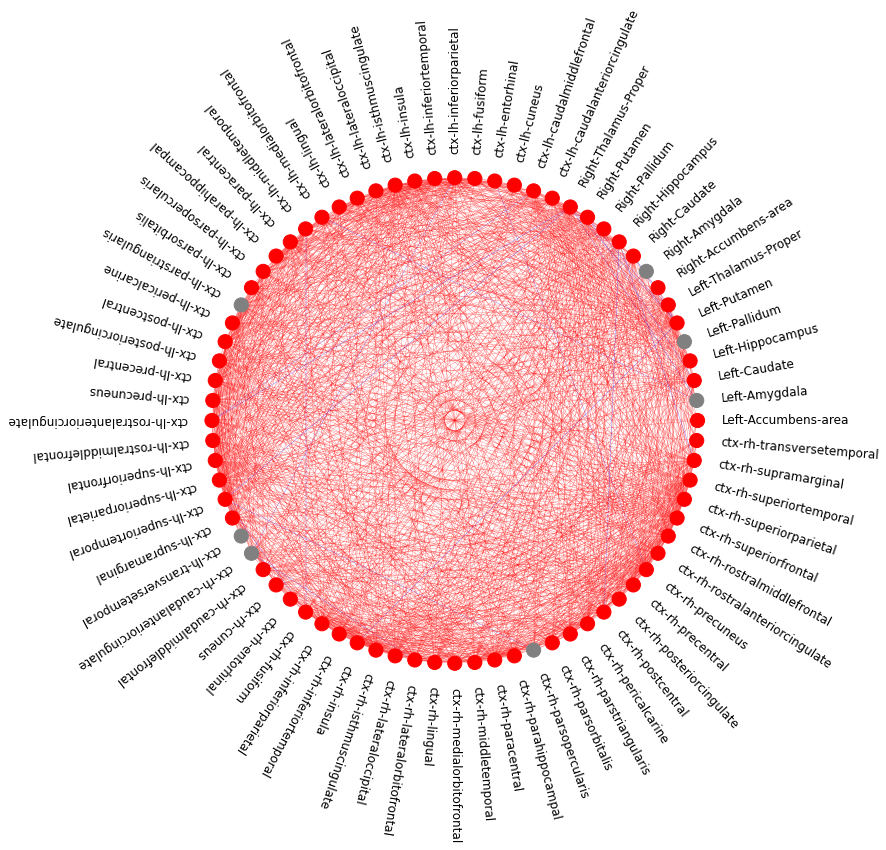

In [76]:
G=nx.Graph()
G.add_nodes_from(nodes)
node_colors = node_strength_sigdif(patients_FA_node_metrics, controls_FA_node_metrics)[0]
edges_list = edge_colors.keys()
G.add_edges_from(edges_list)
edge_colors2 = [edge_colors[(u,v)] for u,v in edge_colors]
labels={}


node_list = sorted(G.nodes())
n= len(G.nodes())
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

for node in G.nodes:
    labels[node]=str(node)
    
# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(24,24))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, node_size=200, 
        node_color = node_colors, edge_color = edge_colors2,
        width=0.2)
description = nx.draw_networkx_labels(G,pos,labels=labels)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.1+(bbdata.width)/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)


plt.show()